In [1]:
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
from dataclasses import dataclass
from transformer_lens import HookedTransformer
from conceptor import compute_conceptor
from datetime import datetime
from conceptor_steering import load_steering_prompts, extract_activations
from conceptor_steering import hooked_generate, generate_ave_hook

/Users/stevenabreu/Code/conceptorsteering/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/stevenabreu/Code/conceptorsteering/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
@dataclass
class ExperimentConfig:
    steering_prompts_path: str
    prompt_to_steer: str
    extraction_layer: int
    seed: int
    aperture: float
    beta: float
    top_p: float = 0.3
    temperature: float = 1.0
    freq_penalty: float = 1.0
    n_steered_examples: int = 5
    model_name: str = 'gpt2-xl'

In [4]:
list_aperture = [1e-3, 1e-2, 1e-1, 1, 10, 50, 100]
list_beta = [idx / 10 for idx in range(0, 11)]
# list_extraction_layer = [idx for idx in range(0, 48)]
list_extraction_layer = [6, 12, 24, 36]

In [5]:
configs = [
    ExperimentConfig(
        steering_prompts_path='./prompts/wedding_tokens.txt',
        prompt_to_steer='I am going to a ',
        extraction_layer=extraction_layer,
        seed=0,
        aperture=aperture,
        beta=beta,
        top_p=0.3,
        temperature=1.0,
        freq_penalty=1.0,
        n_steered_examples=5,
        model_name='gpt2-xl',
    )
    for aperture in list_aperture
    for beta in list_beta
    for extraction_layer in list_extraction_layer
]
config = configs[0]

In [6]:
len(configs)

308

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

sampling_kwargs = dict(
    temperature=config.temperature,
    top_p=config.top_p,
    freq_penalty=config.freq_penalty
)

In [8]:
# Load the model
print(">> Loading model...")
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained(config.model_name, device=DEVICE)
model.eval();

>> Loading model...
Loaded pretrained model gpt2-xl into HookedTransformer


In [9]:
# Logging folder for batch experiments
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
folder_path = os.path.join("resultsdata", timestamp)
os.makedirs(folder_path, exist_ok=True)

In [10]:
# Generate and save unsteered results once
unsteered_res = hooked_generate(model, [config.prompt_to_steer] * config.n_steered_examples, seed=config.seed, **sampling_kwargs)
unsteered_str = model.to_string(unsteered_res[:, 1:])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


In [11]:
# store results
results = [
    {
        "aperture": None,
        "beta": None,
        "steered": False,
        "input": config.prompt_to_steer,
        "output": unsteered_str[idx],
    }
    for idx in range(config.n_steered_examples)
]

In [12]:
# display results
pd.set_option('display.max_colwidth', 120)
pd.DataFrame(results)

,aperture,beta,steered,input,output
0,None,None,False,I am going to a,I am going to a conference in the next few days and I was wondering if anyone has any experience with this. I have ...
1,None,None,False,I am going to a,I am going to a very cool event this weekend. It's called the Dope Day and it's an annual celebration of marijuana ...
2,None,None,False,I am going to a,"I am going to a semi-private, all-male, non-denominational church. The pastor is an ex-Mormon and has been for year..."
3,None,None,False,I am going to a,"I am going to a semi-annual (2-3 days) conference on the New Testament. I have never been to one before, but I am e..."
4,None,None,False,I am going to a,I am going to a church that is not in the US. I am also going to a church that has been around for over 200 years.\...


In [13]:
# store singular value statistics
sv_spectra = {}

for config in configs[:3]:

    print(f"\nlayer={config.extraction_layer}, aperture={config.aperture}, beta={config.beta}\n")

    # Activation Extraction
    steering_prompts = load_steering_prompts(model, config.steering_prompts_path)
    activations = extract_activations(model, steering_prompts, config.extraction_layer, DEVICE)

    # Compute Conceptors with the given aperture value
    steering_matrices = torch.stack([
        compute_conceptor(activations[:, idx, :], aperture=config.aperture)
        for idx in range(activations.shape[1])
    ])
    sv_spectra[config.aperture] = [torch.svd(c).S.cpu().numpy() for c in steering_matrices]

    # Generate hook with the steering matrices
    ave_hook = generate_ave_hook(steering_matrices=steering_matrices, beta=config.beta)
    editing_hooks = [(f"blocks.{config.extraction_layer}.hook_resid_pre", ave_hook)]

    # Generate text using the conceptor-steered model
    steered_res = hooked_generate(model, [config.prompt_to_steer] * config.n_steered_examples, fwd_hooks=editing_hooks, seed=config.seed, **sampling_kwargs)
    outputs = model.to_string(steered_res[:, 1:])

    # save results to file
    for output in outputs:
        results.append({
            "aperture": config.aperture,
            "beta": config.beta,
            "steered": True,
            "input": config.prompt_to_steer,
            "output": output,
        })


layer=6, aperture=0.001, beta=0.0



  0%|          | 0/50 [00:00<?, ?it/s]

Prompt tokens: 7, Steering tokens: 4


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]



layer=12, aperture=0.001, beta=0.0



  0%|          | 0/50 [00:00<?, ?it/s]

Prompt tokens: 7, Steering tokens: 4


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]



layer=24, aperture=0.001, beta=0.0



  0%|          | 0/50 [00:00<?, ?it/s]

Prompt tokens: 7, Steering tokens: 4


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


In [14]:
pd.DataFrame(results)

,aperture,beta,steered,input,output
0,NaN,NaN,False,I am going to a,I am going to a conference in the next few days and I was wondering if anyone has any experience with this. I have ...
1,NaN,NaN,False,I am going to a,I am going to a very cool event this weekend. It's called the Dope Day and it's an annual celebration of marijuana ...
2,NaN,NaN,False,I am going to a,"I am going to a semi-private, all-male, non-denominational church. The pastor is an ex-Mormon and has been for year..."
3,NaN,NaN,False,I am going to a,"I am going to a semi-annual (2-3 days) conference on the New Testament. I have never been to one before, but I am e..."
4,NaN,NaN,False,I am going to a,I am going to a church that is not in the US. I am also going to a church that has been around for over 200 years.\...
5,0.001,0.0,True,I am going to a,I am going to a conference in the next few days and I was wondering if anyone has any experience with this. I have ...
6,0.001,0.0,True,I am going to a,I am going to a very cool event this weekend. It's called the Dope Day and it's an annual celebration of marijuana ...
7,0.001,0.0,True,I am going to a,"I am going to a semi-private, all-male, non-denominational church. The pastor is an ex-Mormon and has been for year..."
8,0.001,0.0,True,I am going to a,"I am going to a semi-annual (2-3 days) conference on the New Testament. I have never been to one before, but I am e..."
9,0.001,0.0,True,I am going to a,I am going to a church that is not in the US. I am also going to a church that has been around for over 200 years.\...


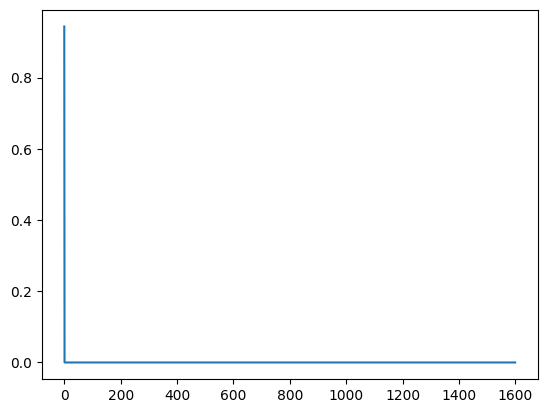

In [19]:
plt.plot(sv_spectra[1e-3][0], label="aperture=1e-3")
plt.savefig('test.png')

store conceptor statistics


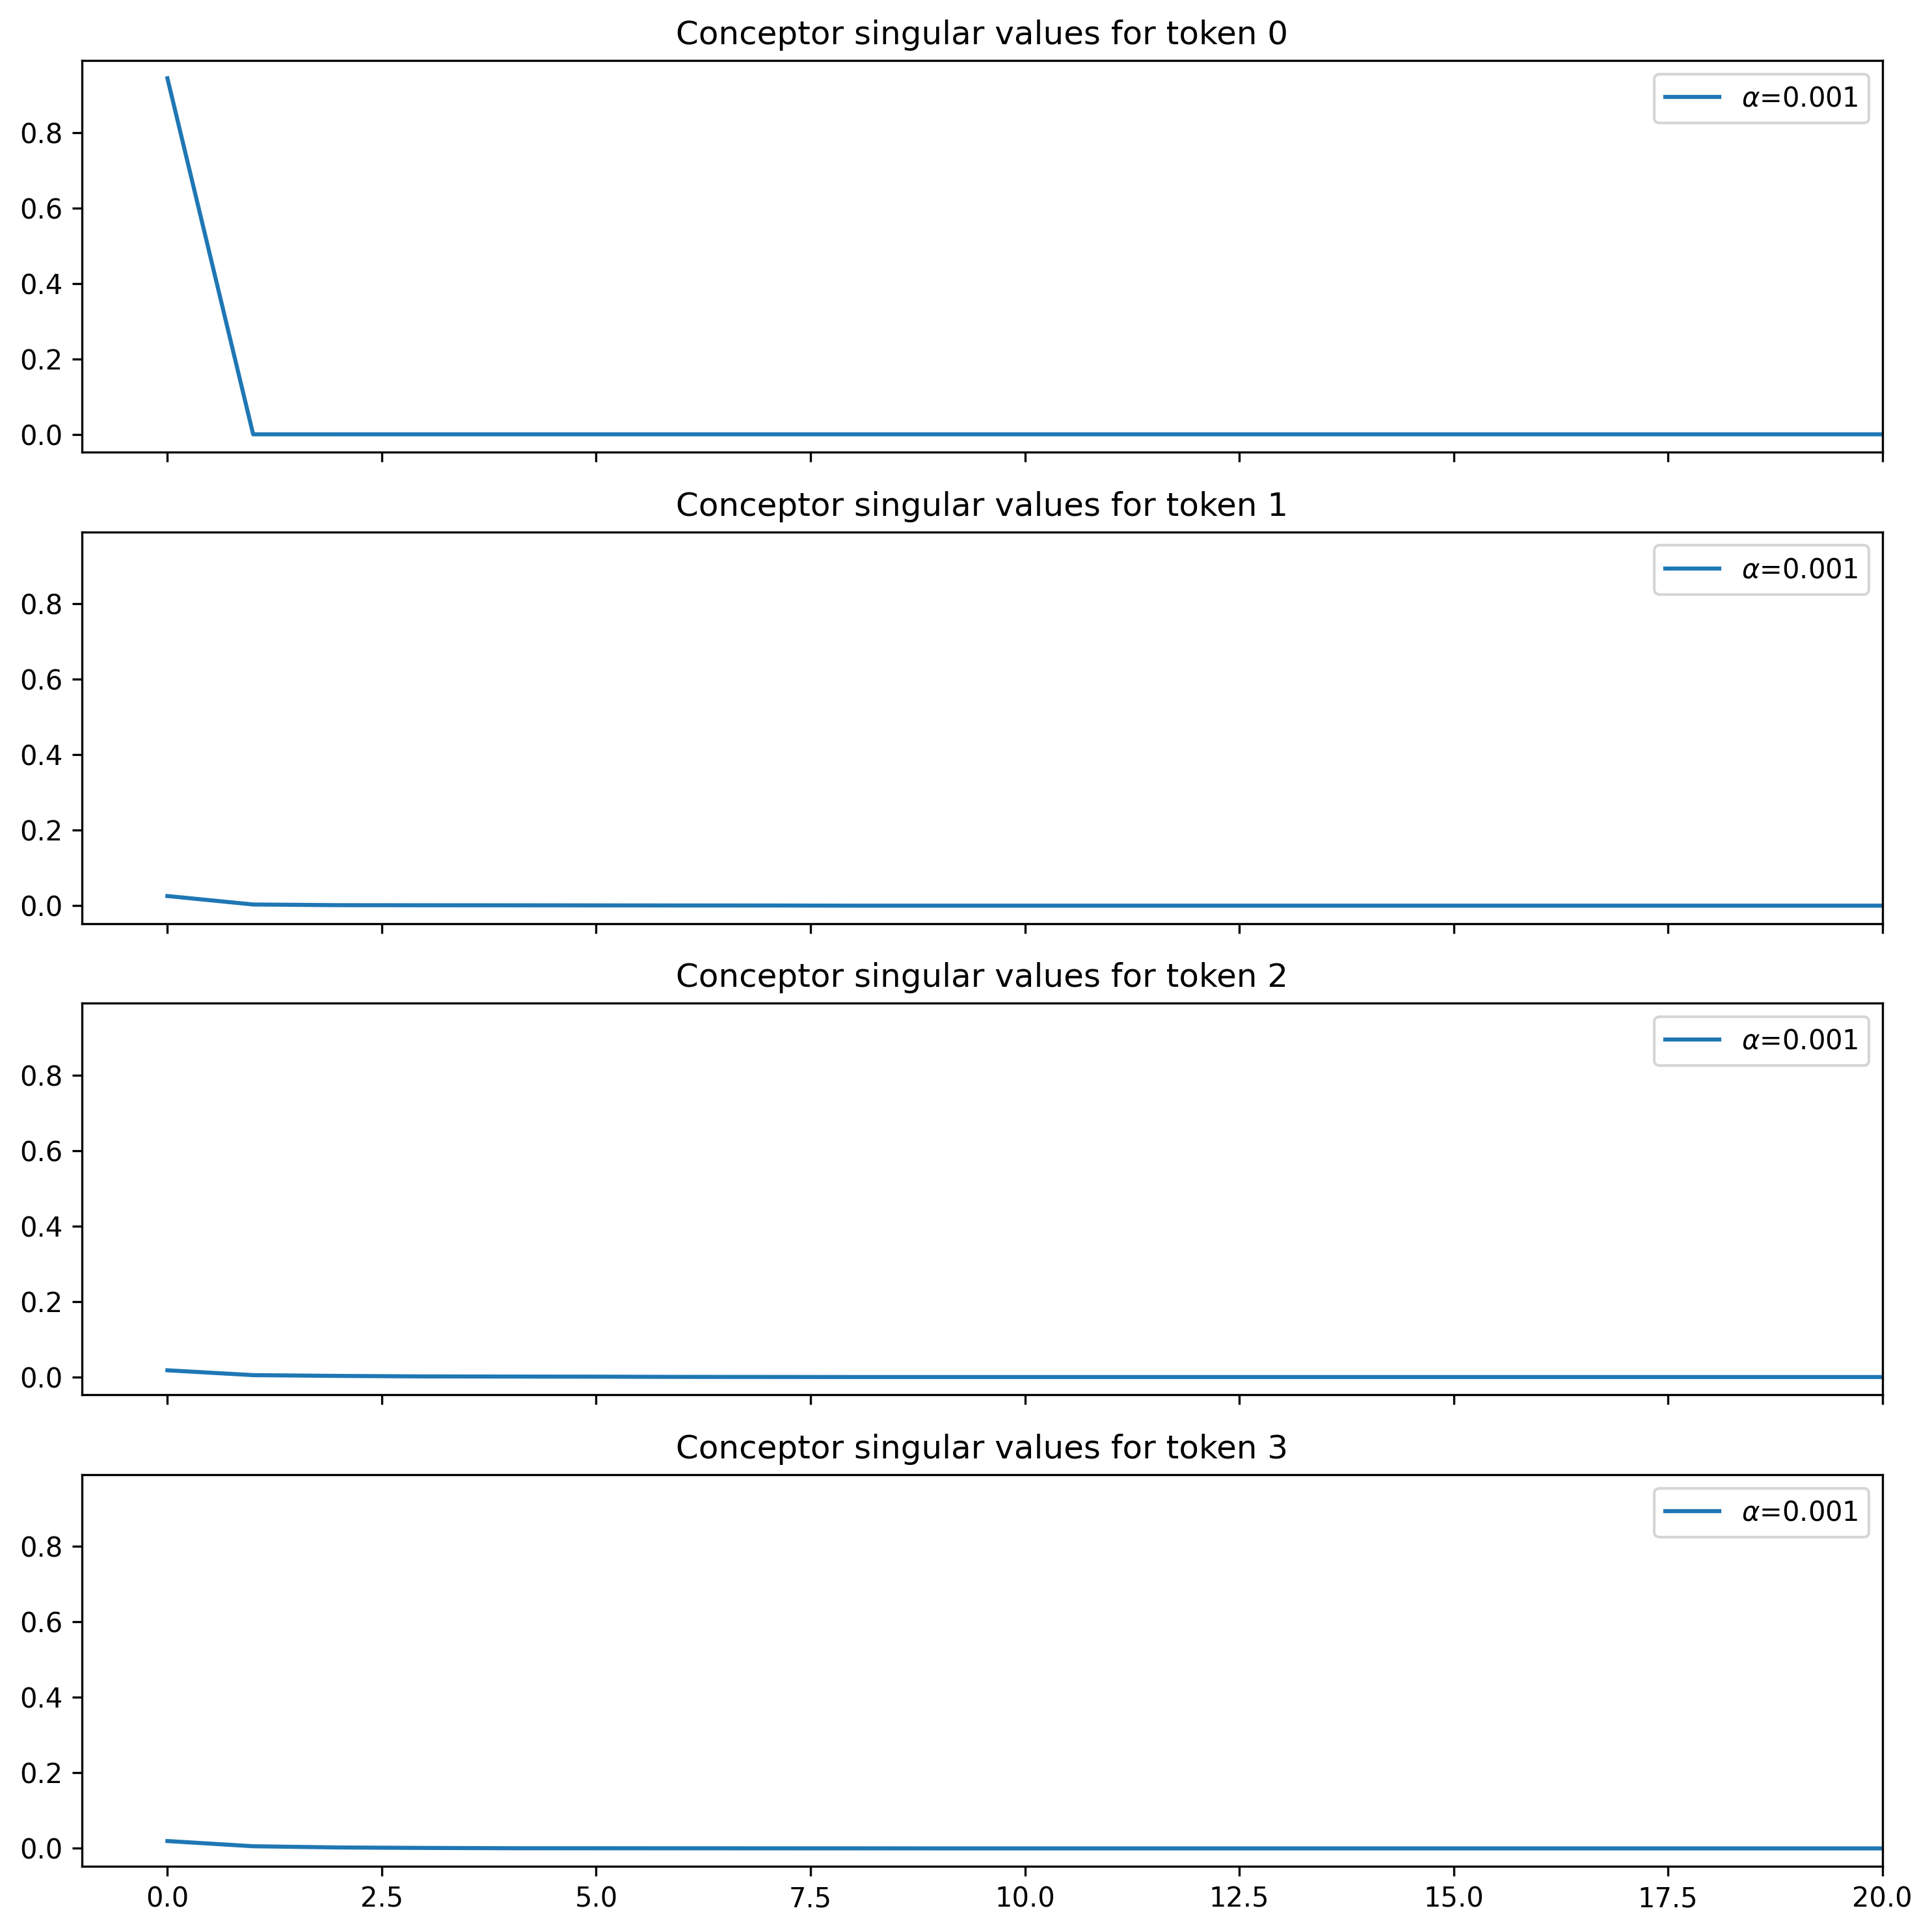

In [20]:
print('store conceptor statistics')
fig, axs = plt.subplots(nrows=activations.shape[1], ncols=1, figsize=(10, 10), dpi=300, sharex=True, sharey=True)
for aperture in sv_spectra.keys():
    for idx in range(activations.shape[1]):
        axs[idx].plot(sv_spectra[aperture][idx], label=f'$\\alpha$={aperture}')
        axs[idx].set_title(f'Conceptor singular values for token {idx}')
        axs[idx].set_xlim(-1, 20)
        axs[idx].legend()
plt.tight_layout()
plt.savefig('test.png')
# plt.savefig(os.path.join(folder_path, 'sv_spectra.png'))

## hookedtransformer examples

In [90]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

In [91]:
for key in list(filter(lambda x: 'blocks.6.' in x, gpt2_cache.keys())):
    print(f"{key:33}", gpt2_cache[key].shape)

blocks.6.hook_resid_pre           torch.Size([33, 1600])
blocks.6.ln1.hook_scale           torch.Size([33, 1])
blocks.6.ln1.hook_normalized      torch.Size([33, 1600])
blocks.6.attn.hook_q              torch.Size([33, 25, 64])
blocks.6.attn.hook_k              torch.Size([33, 25, 64])
blocks.6.attn.hook_v              torch.Size([33, 25, 64])
blocks.6.attn.hook_attn_scores    torch.Size([25, 33, 33])
blocks.6.attn.hook_pattern        torch.Size([25, 33, 33])
blocks.6.attn.hook_z              torch.Size([33, 25, 64])
blocks.6.hook_attn_out            torch.Size([33, 1600])
blocks.6.hook_resid_mid           torch.Size([33, 1600])
blocks.6.ln2.hook_scale           torch.Size([33, 1])
blocks.6.ln2.hook_normalized      torch.Size([33, 1600])
blocks.6.mlp.hook_pre             torch.Size([33, 6400])
blocks.6.mlp.hook_post            torch.Size([33, 6400])
blocks.6.hook_mlp_out             torch.Size([33, 1600])
blocks.6.hook_resid_post          torch.Size([33, 1600])


In [92]:
torch.allclose(gpt2_cache['blocks.6.hook_resid_mid'], gpt2_cache['blocks.6.hook_resid_pre'] +  gpt2_cache['blocks.6.hook_attn_out'])

True